<a href="https://colab.research.google.com/github/AndresInsuasty/tesis-cafes-especiales/blob/main/AutoencoderNDVI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pix2pix para segmentado de imagenes NDVI


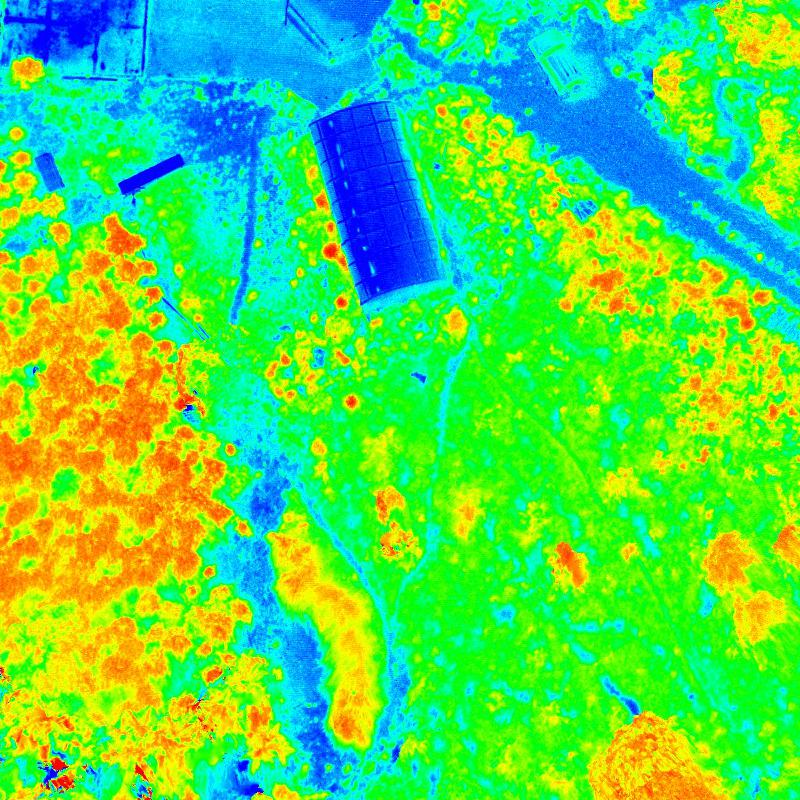



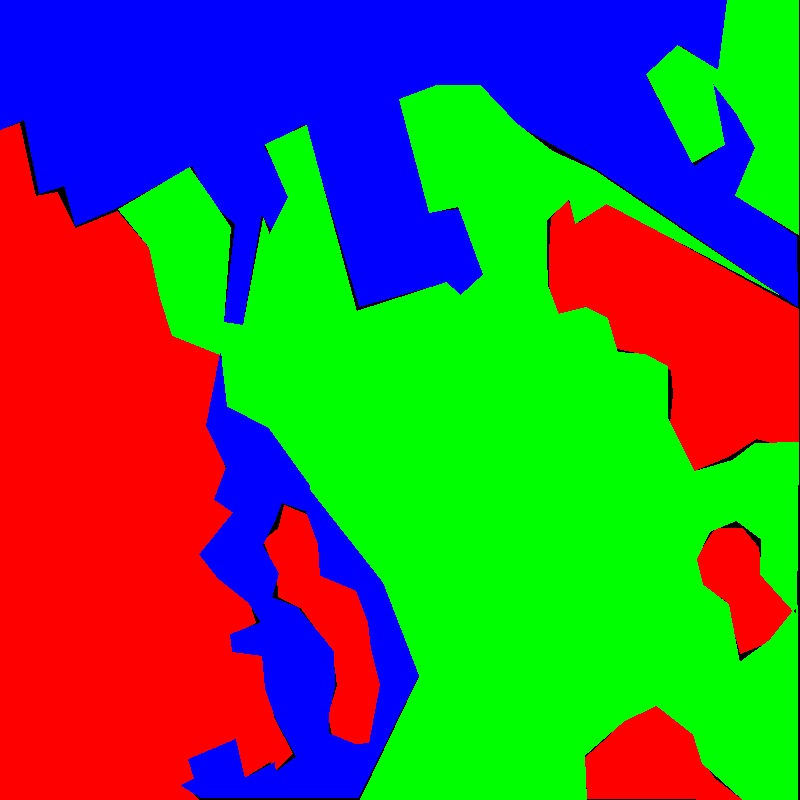{ width: 200px; }

## Librerias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob
from google.colab.patches import cv2_imshow


import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt

In [2]:
# Ruta raiz
PATH = "/content/drive/MyDrive/segmentado/pix2pix"

# Ruta de datos de entrada
INPATH = PATH + '/imagenes_ndvi/'
# Ruta de salida
OUTPATH = PATH + '/imagenes_segmentadas/'
# Ruta de los checkpoints
CKPATH = PATH + '/chechpoints'

## Listar Archivos

In [3]:
imgurls = !ls -1 "{INPATH}"

## Particionar Dataset

In [4]:
 n = len(imgurls)
 train_n = round(n*0.8)
 
 # Particion Train/Test
 tr_urls = imgurls[:train_n]
 ts_urls = imgurls[train_n:n]

In [5]:
print('El tamaño total del dataset es {} \n Entrenamiento: {} \n Testeo: {} '.format(len(imgurls),len(tr_urls),len(ts_urls)))

El tamaño total del dataset es 301 
 Entrenamiento: 241 
 Testeo: 60 


## Cargando imagenes

In [6]:
def leer_imagen(path):
    dim = (256,256)
    im = cv2.imread(path)
    im_r = cv2.resize(im,dim)
    return im_r

In [7]:
def load_data(urls,path):
    im_s = np.empty((1, 256,256,3))
    im_aux = np.empty((1, 256,256,3))
    cont=0
    for url in urls:
        im = leer_imagen(path + url)
        if cont == 0:
            im_s[0,...] = im
            cont +=1
        else:
            im_aux[0,...] = im
            im_s = np.append(im_s,im_aux,axis=0)
    if cont %100 ==0:
        print(cont)
    return im_s

### Entrada

In [8]:
x = load_data(imgurls,INPATH)
x.shape

(301, 256, 256, 3)

### Salida

In [9]:
y = load_data(imgurls,OUTPATH)
y.shape

(301, 256, 256, 3)

### Visualización

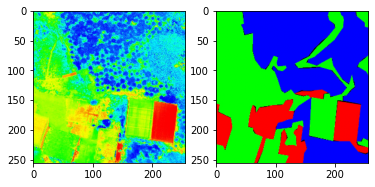

In [10]:
img_n = 40
plt.subplot(121)
plt.imshow(x[img_n,...]/255)
plt.subplot(122)
plt.imshow(y[img_n,...]/255)
plt.show()

## Partir en entrenamiento y test

In [11]:
x_train = x[0:241,...]/255
y_train = y[0:241,...]/255

x_test = x[241:-1,...]/255
y_test = y[241:-1,...]/255

print('El tamaño total del dataset es {} \n Entrenamiento: {} \n Testeo: {} '.format(len(imgurls),x_train.shape[0],x_test.shape[0]))

El tamaño total del dataset es 301 
 Entrenamiento: 241 
 Testeo: 59 


In [12]:
x_test.shape

(59, 256, 256, 3)

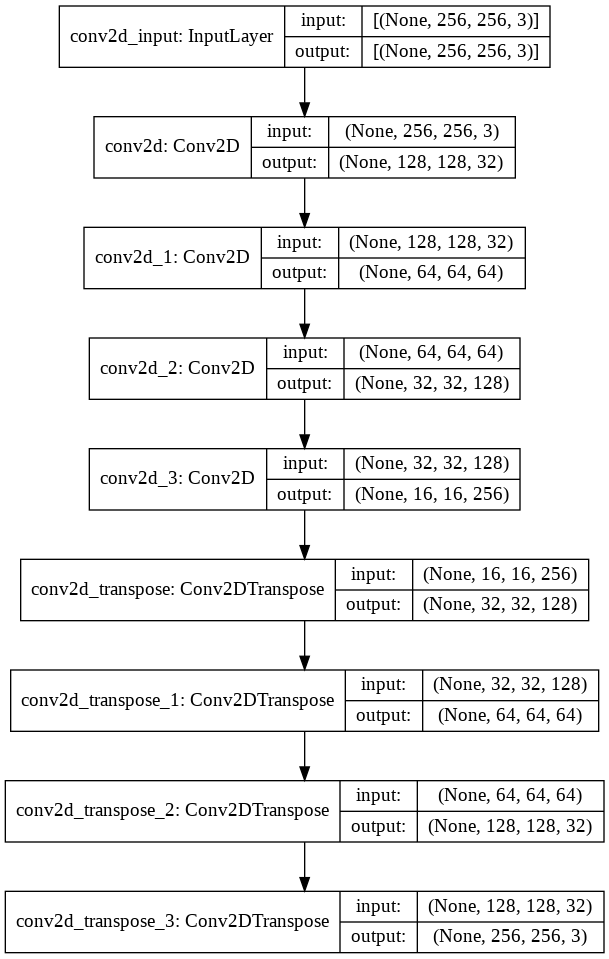

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(32, 
                    kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='relu', input_shape=(256, 256, 3)))
model.add(layers.Conv2D(64, kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='relu'))
model.add(layers.Conv2D(128, kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='relu'))
model.add(layers.Conv2D(256, kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='relu'))
model.add(layers.Conv2DTranspose(128,
                    kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='relu',
                    use_bias = False))
model.add(layers.Conv2DTranspose(64,
                    kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='relu',
                    use_bias = False))
model.add(layers.Conv2DTranspose(32,
                    kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='relu',
                    use_bias = False))
model.add(layers.Conv2DTranspose(3,
                    kernel_size = 4,
                    strides=2,
                    padding="same",
                    activation='softmax',
                    use_bias = False))
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
)

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy')

In [15]:
history=model.fit(x_train, x_train,
                epochs=102,
                batch_size=16,
                validation_data=(x_test, x_test),
                shuffle=True)

Epoch 1/102
16/16 [==============================] - 5s 160ms/step - loss: 0.6077 - val_loss: 0.5935
Epoch 2/102
16/16 [==============================] - 2s 100ms/step - loss: 0.5261 - val_loss: 0.5792
Epoch 3/102
16/16 [==============================] - 2s 101ms/step - loss: 0.5139 - val_loss: 0.5788
Epoch 4/102
16/16 [==============================] - 2s 101ms/step - loss: 0.5066 - val_loss: 0.5591
Epoch 5/102
16/16 [==============================] - 2s 99ms/step - loss: 0.4534 - val_loss: 0.4837
Epoch 6/102
16/16 [==============================] - 2s 100ms/step - loss: 0.4049 - val_loss: 0.4720
Epoch 7/102
16/16 [==============================] - 2s 100ms/step - loss: 0.3955 - val_loss: 0.4677
Epoch 8/102
16/16 [==============================] - 2s 100ms/step - loss: 0.3721 - val_loss: 0.4476
Epoch 9/102
16/16 [==============================] - 2s 100ms/step - loss: 0.3588 - val_loss: 0.4502
Epoch 10/102
16/16 [==============================] - 2s 99ms/step - loss: 0.3583 - val_loss

In [16]:
model.save(PATH+"/autoencoderPix2Pix20212709.h5")

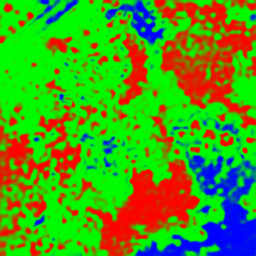

In [17]:
cv2_imshow(model.predict(x_test[0:1,...])[0,...]*255)

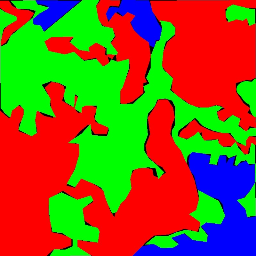

In [20]:
cv2_imshow(y_test[0,...]*255)